In [45]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
import copy
from tqdm.notebook import tqdm
import random

from kaggle_environments import make

import gym

import matplotlib.pyplot as plt

In [24]:
#Envrionment parameters
cols = 7
rows = 6

env = make("connectx", configuration={"rows":rows, "columns":cols})

In [101]:
# Here we define some hyperparameters and the agent's architecture

observation_space = gym.spaces.Discrete(cols * rows).n
action_space = gym.spaces.Discrete(cols)


EPISODES = 10000
LR = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 64
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001
sync_freq = 10

class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = (cols*rows,)
        self.action_space = action_space.n

        self.fc1 = nn.Linear(*self.input_shape, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LR)
        self.loss = nn.MSELoss()
        #self.to(DEVICE)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [102]:
class ReplayBuffer:
    def __init__(self):
        self.memory = deque(maxlen=MEM_SIZE)
    
    def add(self, experience):
        self.memory.append(experience)
    
    def sample(self):
        minibatch = random.sample(self.memory, BATCH_SIZE)

        state1_batch = torch.stack([s1 for (s1,a,r,s2,d) in minibatch])
        action_batch = torch.tensor([a for (s1,a,r,s2,d) in minibatch])
        reward_batch = torch.tensor([r for (s1,a,r,s2,d) in minibatch])
        state2_batch = torch.stack([s2 for (s1,a,r,s2,d) in minibatch])
        done_batch = torch.tensor([d for (s1,a,r,s2,d) in minibatch])

        return (state1_batch, action_batch, reward_batch, state2_batch, done_batch)

In [103]:
class DQN:
    def __init__(self):
        self.replay = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()
        self.network2 = copy.deepcopy(self.network) #A
        self.network2.load_state_dict(self.network.state_dict())


    def choose_action(self, observation):
        if random.random() < self.exploration_rate:
            return action_space.sample()

        # Convert observation to PyTorch Tensor
        state = torch.tensor(observation).float().detach()
        #state = state.to(DEVICE)
        state = state.unsqueeze(0)
            
        ### BEGIN SOLUTION ###

        # Get Q(s,.)
        q_values = self.network(state)

        # Choose the action to play
        action = torch.argmax(q_values).item()

        ### END SOLUTION ###

        return action


    def learn(self):
        if len(self.replay.memory)< BATCH_SIZE:
            return

        ### BEGIN SOLUTION ###

        # Sample minibatch s1, a1, r1, s1', done_1, ... , sn, an, rn, sn', done_n
        state1_batch, action_batch, reward_batch, state2_batch, done_batch = self.replay.sample()

        # Compute Q values
        q_values = self.network(state1_batch).squeeze()

        with torch.no_grad():
            # Compute next Q values
            next_q_values = self.network2(state2_batch).squeeze()

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)

        predicted_value_of_now = q_values[batch_indices, action_batch]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0]

        # Compute the q_target
        q_target = reward_batch + GAMMA * predicted_value_of_future * (1-(done_batch).long())

        # Compute the loss (c.f. self.network.loss())
        loss = self.network.loss(q_target, predicted_value_of_now)

        ### END SOLUTION ###

        # Complute 𝛁Q
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)


    def returning_epsilon(self):
        return self.exploration_rate

/var/folders/h7/kxfwd0yn5zs4hb0z6ftkjj9h0000gn/T/ipykernel_73575/3647063140.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).float()
/var/folders/h7/kxfwd0yn5zs4hb0z6ftkjj9h0000gn/T/ipykernel_73575/3448865454.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(observation).float().detach()


Episode 10 Average Reward -0.4 Best Reward 1 Last Reward 1 Epsilon 0.9684910757595269
Episode 20 Average Reward -0.25 Best Reward 1 Last Reward -1 Epsilon 0.8824417114557717
Episode 30 Average Reward -0.1 Best Reward 1 Last Reward 1 Epsilon 0.8024304668606914
Episode 40 Average Reward -0.1 Best Reward 1 Last Reward -1 Epsilon 0.7173681503955072
Episode 50 Average Reward -0.28 Best Reward 1 Last Reward -1 Epsilon 0.6413229363226717
Episode 60 Average Reward -0.2 Best Reward 1 Last Reward 1 Epsilon 0.5820082358133997
Episode 70 Average Reward -0.08571428571428572 Best Reward 1 Last Reward 1 Epsilon 0.5276512561805725
Episode 80 Average Reward -0.125 Best Reward 1 Last Reward 1 Epsilon 0.47077417846163544
Episode 90 Average Reward -0.13333333333333333 Best Reward 1 Last Reward 1 Epsilon 0.41501534097911913
Episode 100 Average Reward -0.11 Best Reward 1 Last Reward -1 Epsilon 0.3804184978064605
Episode 110 Average Reward -0.10909090909090909 Best Reward 1 Last Reward 1 Epsilon 0.3407731204

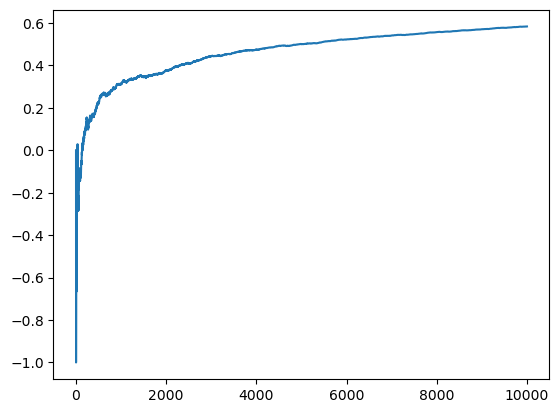

In [104]:
agent = DQN()

trainer = env.train([None, "random"])

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

j=0
for i in range(1, EPISODES):
    state, info = env.reset()
    state = state["observation"]["board"]
    state = np.reshape(state, [1, observation_space])
    score = 0

    while True:
        j+=1

        action = agent.choose_action(state)
        state_, reward, done, info = trainer.step(action)
        if reward == None :
            reward = -2
        state_ = state_["board"]
        state_ = np.reshape(state_, [1, observation_space])
        state = torch.tensor(state).float()
        state_ = torch.tensor(state_).float()

        exp = (state, action, reward, state_, done)
        agent.replay.add(exp)
        agent.learn()

        state = state_
        score += reward

        if j % sync_freq == 0:
            agent.network2.load_state_dict(agent.network.state_dict())

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score 
            if i%10==0:
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                #test_model(agent,10, observation_space)
            break
  
        episode_number.append(i)
        average_reward_number.append(average_reward/i)

plt.plot(episode_number, average_reward_number)
plt.show()

In [105]:
def test_model(model, num_episodes, observation_space):

    for i_episode in range(num_episodes):
        G=0
        observation, info = env.reset()
        done = False
        while not done:
            observation = torch.from_numpy(observation).float()
            observation = np.reshape(observation, [1, observation_space])
            action = model.choose_action(observation)
            observation, reward, done, truncated, info = env.step(action)
            G += reward
            if done:
                print(G)
                break

In [108]:
observation, info = env.reset()
observation = observation["observation"]


nb_games = 0
history = {1:0, -1:0, None:0}
while nb_games < 1000:
    env.render()
    
    if done :
        #print(np.reshape(observation["board"], (6,7)))
        observation, info = env.reset()
        observation = observation["observation"]
        history[reward] += 1
        nb_games +=1
    
    action = agent.choose_action(np.reshape(observation["board"], [1, observation_space]))
    observation, reward, done, info = trainer.step(action)

In [109]:
print(history)

{1: 854, -1: 136, None: 10}
